# Самостоятельный проект. Обучение с учителем: качество модели

## 1. Введение

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

#### Шаги по решению задачи:
- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
- Нужно собрать данные по клиентам по следующим группам:
  * Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
  * Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто
  * Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магази
  * Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте
 
#### Требования
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.нные предложения.ь.

## 2. Загрузка данных

In [1]:
!pip install phik
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.svm import SVC
import shap
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('max_colwidth', -1)

RANDOM_STATE = 42
TEST_SIZE = 0.25
sns.set()

In [3]:
df_market = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
display(df_market.head(5))
df_market.info()

df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
display(df_market_money.head(5))
df_market_money.info()

df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
display(df_market_time.head(5))
df_market_time.info()

df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal=",")
display(df_money.head(5))
df_money.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Загружены данные из четырех CSV файлов в соответствующие датафреймы. Данные представляются соответствующими названиям колонок, в числовых колонках лежат числовые данные а в категориальных - категориальные. Названия колонок являются консистентными между датафреймами и необходимости приводить их к единому формату нет.

## 3. Предобработка данных

In [4]:
def print_unique_values_for_string_columns(df_list):
    for df_name, df in df_list:
        print('')
        print(f'************ df is {df_name} **************')
        col_list = df.select_dtypes(exclude=np.number).columns
        for col in col_list:
            print(f'*** column is {col}')
            print(df[col].value_counts())


print(f'Количество дубликтов: df_market: {df_market.duplicated(subset="id").sum()}, df_market_money: {df_market_money.duplicated(subset="id").sum()}, df_market_time: {df_market_time.duplicated(subset="id").sum()}, df_money: {df_money.duplicated(subset="id").sum()}')

df_market_str_col_list = df_market.select_dtypes(exclude=np.number).columns
df_market[df_market_str_col_list] = df_market[df_market_str_col_list].astype('string')

df_market_str_col_list = df_market_money.select_dtypes(exclude=np.number).columns
df_market_money[df_market_str_col_list] = df_market_money[df_market_str_col_list].astype('string')

df_market_str_col_list = df_market_time.select_dtypes(exclude=np.number).columns
df_market_time[df_market_str_col_list] = df_market_time[df_market_str_col_list].astype('string')

df_market.info()
df_market_money.info()
df_market_time.info()

print(f'Количество пропусков: df_market: {df_market.isna().mean()}')
print(f'Количество пропусков: df_market_money: {df_market_money.isna().mean()}')
print(f'Количество пропусков: df_market_time: {df_market_time.isna().mean()}')
print(f'Количество пропусков: df_money: {df_money.isna().mean()}')

df_list = [('df_market', df_market), ('df_market_money',df_market_money), ('df_market_time',df_market_time)]
print_unique_values_for_string_columns(df_list)

df_market['Тип сервиса'] = df_market['Тип сервиса'].replace('стандартт', 'стандарт')
# df_market_money['Период'] = df_market_money['Период'].replace('препредыдущий_месяц', 'предыдущий_месяц')
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

print_unique_values_for_string_columns(df_list)
print(f'Количество дубликтов: df_market: {df_market.duplicated(subset="id").sum()}, df_market_money: {df_market_money.duplicated(subset="id").sum()}, df_market_time: {df_market_time.duplicated(subset="id").sum()}, df_money: {df_money.duplicated(subset="id").sum()}')


# df_market=df_market.set_index('id', drop=True)
# df_market_money=df_market_money.set_index('id', drop=True)
# df_market_time=df_market_time.set_index('id', drop=True)
# df_money=df_money.set_index('id', drop=True)

# print(f'Количество дубликтов: df_market: {df_market.duplicated().sum()}, df_market_money: {df_market_money.duplicated().sum()}, df_market_time: {df_market_time.duplicated().sum()}, df_money: {df_money.duplicated().sum()}')

Количество дубликтов: df_market: 0, df_market_money: 2600, df_market_time: 1300, df_money: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   string 
 2   Тип сервиса                          1300 non-null   string 
 3   Разрешить сообщать                   1300 non-null   string 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   string 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Нео

На стадии предобработки данных была проведены следующие проверки: 
- на дубликаты по значению id :
  - для df_market  не обнаружены - то есть нет записей с одним и тем же значением id что представляет собой общий номер покупателя в корпоративной базе данных
  - для df_market_money и df_market_time есть дубликаты по id и это можно объяснить что между df_market и двумя этими таблицами есть отношение One-to-Many
- на пропуски данных - не обнаружены

Кроме того, все поля нечисловых типов были привелены к типу string

После этого была проведена проверка на уникальность значений категориальных полей для обнаружения возможных ошибок ввода. Были обнаружены следующие несоответствия:
- Для датафрейма df_market:
  - Колонка **Тип сервиса**
    - стандарт и стандартт
- Для датафрейма df_market_time:
  - Колонка **Период**
    - предыдцщий_месяц но правильное значение должно быть **предыдущий_месяц**
   
Итого - по результатам проверки были сделаны следующие корректировки:
- В датафрейме df_market в колонке **Тип сервиса** значение **стандартт** переименовано в **стандарт**
- В датафрейме df_market_time в колонке **Период** значение **предыдцщий_месяц** переименовано в **предыдущий_месяц**

Проверка на дубликаты всех полей кроме id не проводилась так как в данном проекте считается, что только id является уникальным идентификатором клиента и если у двух разных клиентов все остальные поля совпадают это не баг и просто совпадение.

## Шаг 4. Исследовательский анализ данных

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


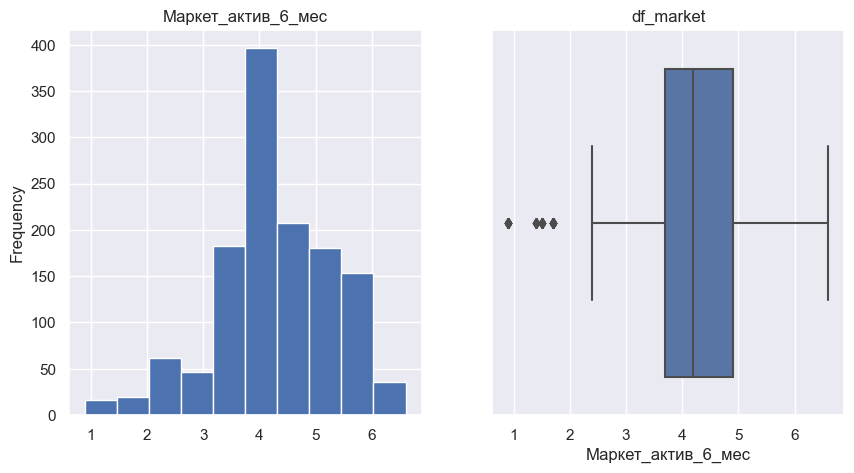

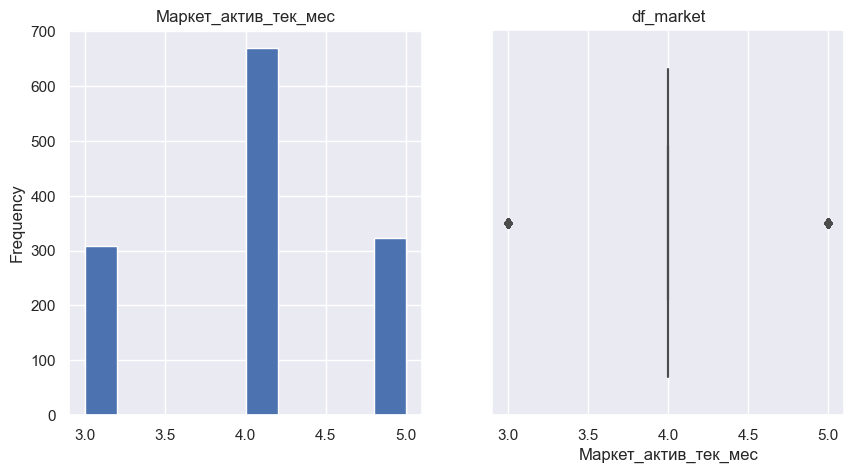

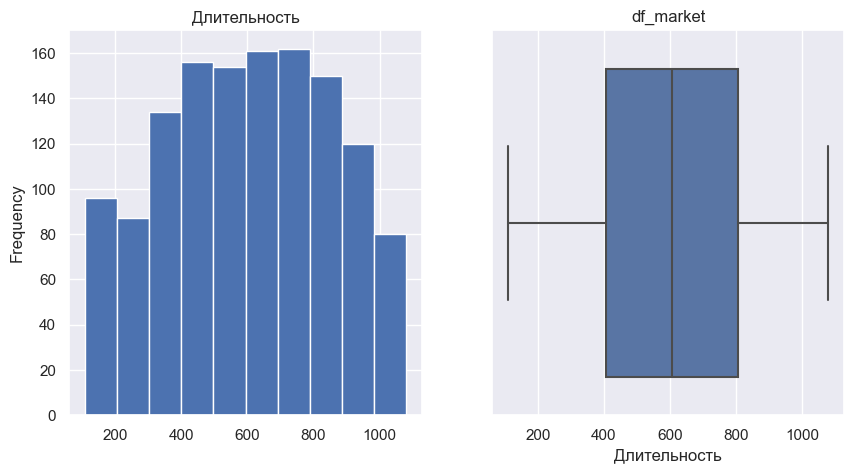

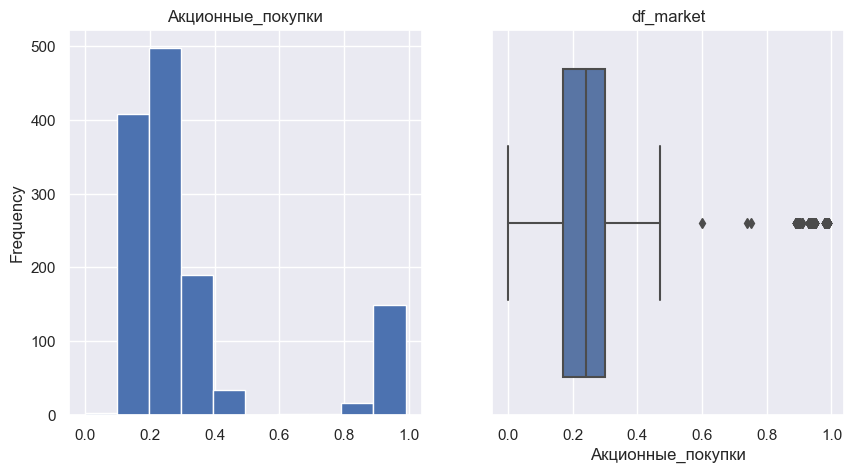

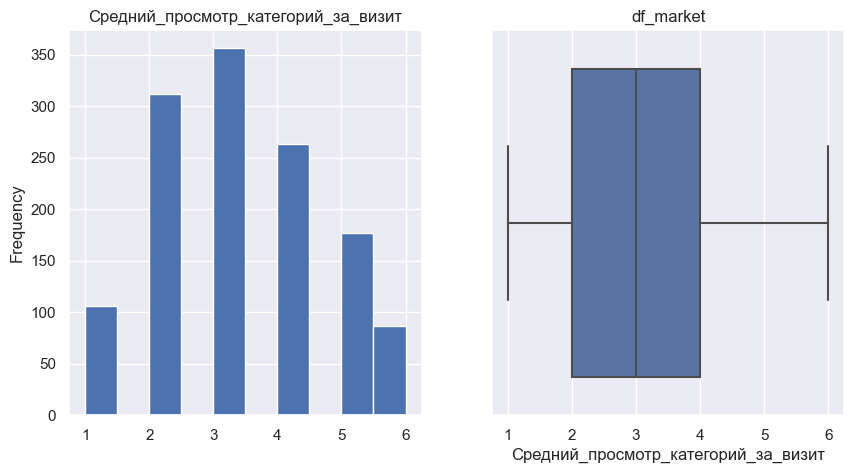

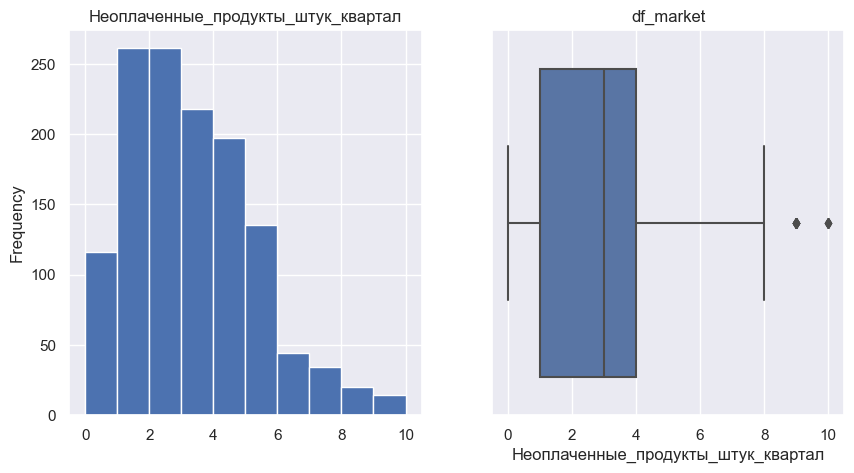

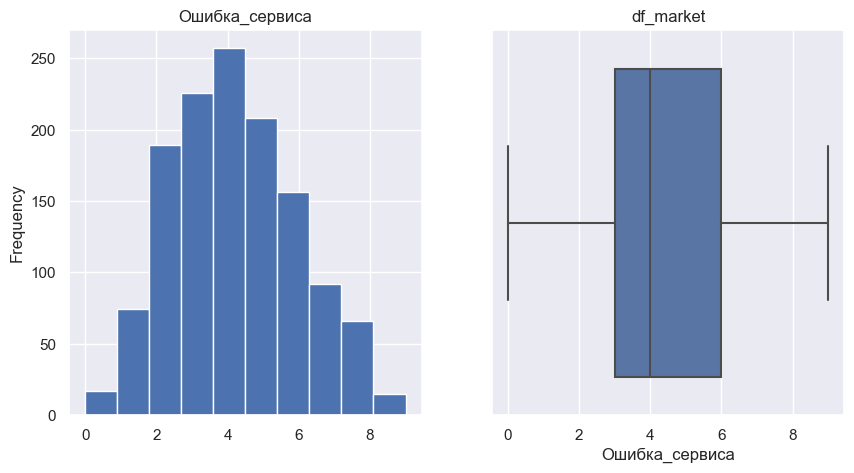

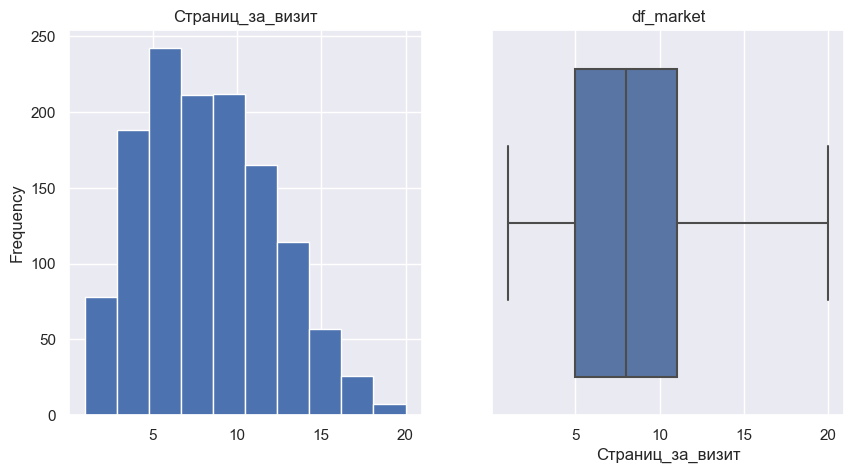

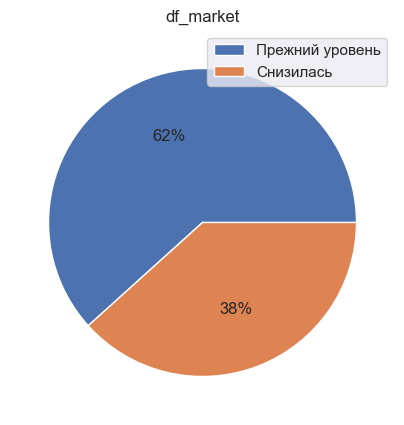

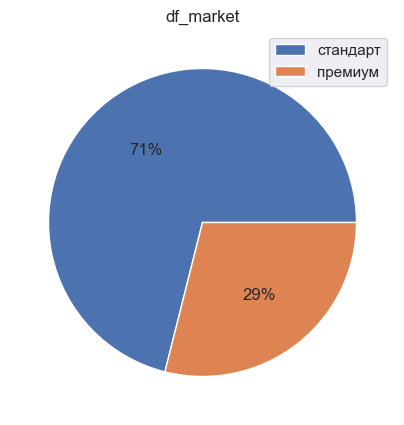

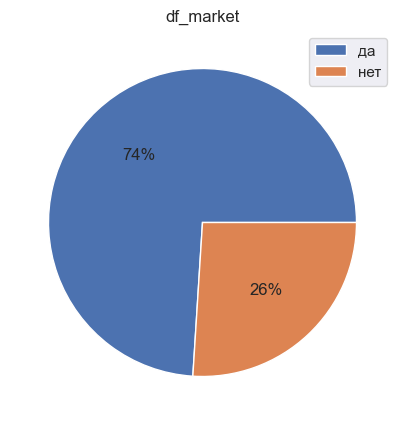

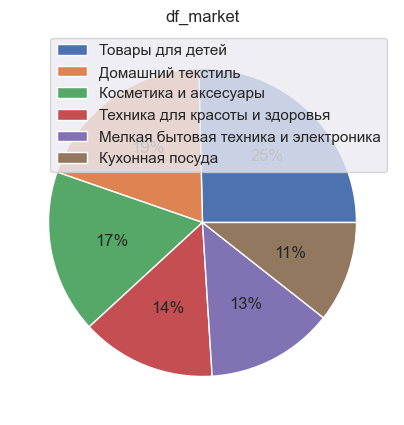

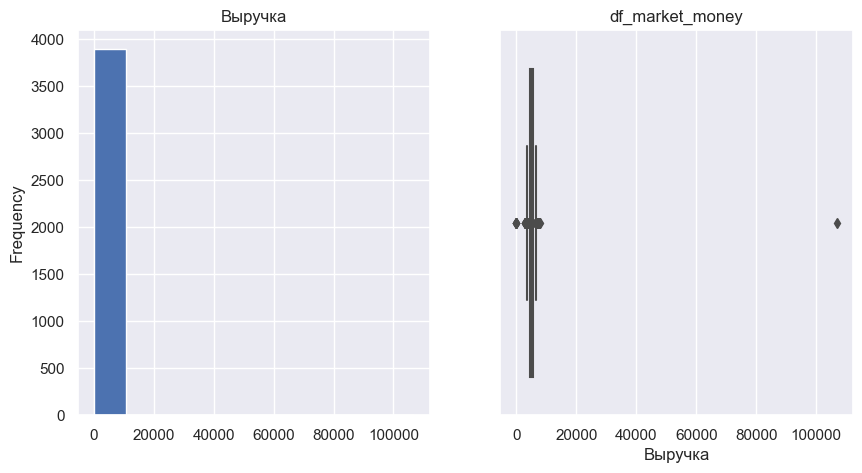

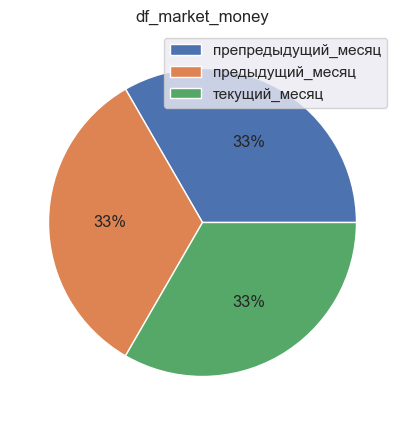

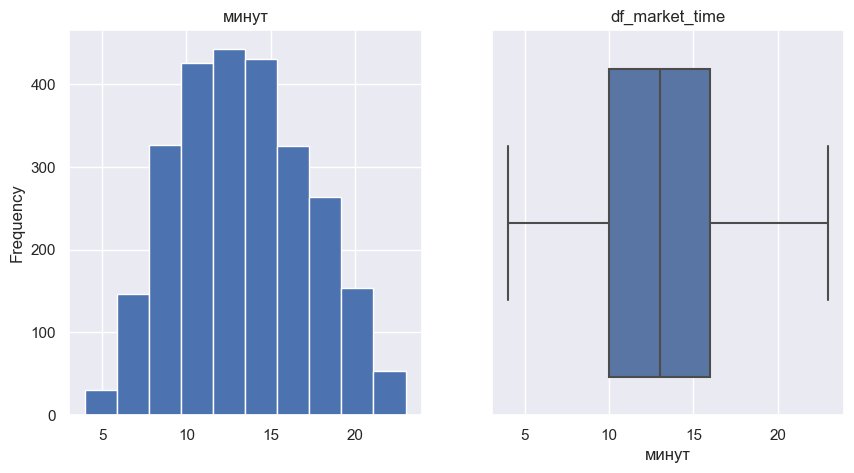

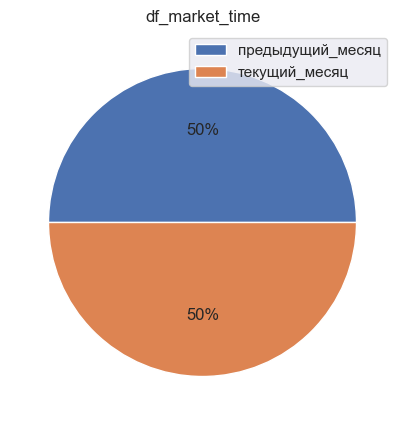

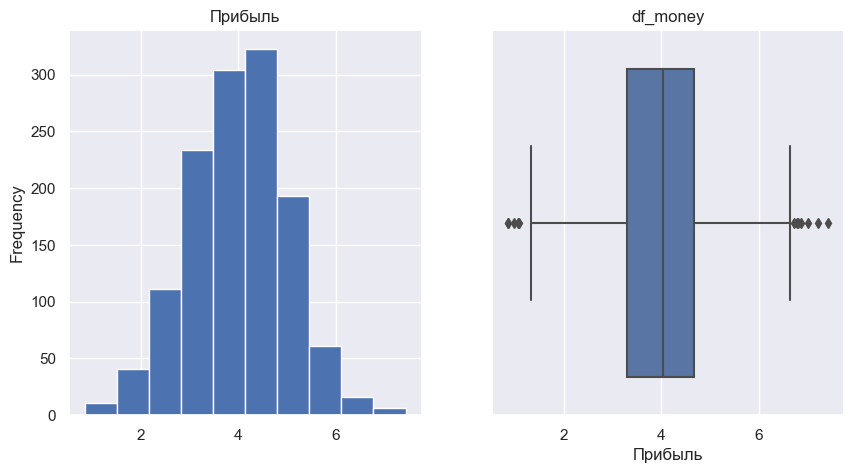

In [5]:
display(df_market.describe())
display(df_market_money.describe())
display(df_market_time.describe())
display(df_money.describe())

def plot_sub_plot_hist_boxplot(df, title):
    for col in df.columns:
        if col == 'id':
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(df[col], ax = axes[1])
        plt.title(title)
        plt.show()

def plot_pie_plot_for_columns(df, title):
    for col in df.columns:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.title(title)
        plt.show()


plot_sub_plot_hist_boxplot(df_market.select_dtypes(include=np.number), 'df_market')
plot_pie_plot_for_columns(df_market.select_dtypes(exclude=np.number), 'df_market')

plot_sub_plot_hist_boxplot(df_market_money.select_dtypes(include=np.number), 'df_market_money')
plot_pie_plot_for_columns(df_market_money.select_dtypes(exclude=np.number), 'df_market_money')

plot_sub_plot_hist_boxplot(df_market_time.select_dtypes(include=np.number), 'df_market_time')
plot_pie_plot_for_columns(df_market_time.select_dtypes(exclude=np.number), 'df_market_time')

plot_sub_plot_hist_boxplot(df_money.select_dtypes(include=np.number), 'df_money')
plot_pie_plot_for_columns(df_money.select_dtypes(exclude=np.number), 'df_money')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   string 
 2   Тип сервиса                          1300 non-null   string 
 3   Разрешить сообщать                   1300 non-null   string 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   string 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


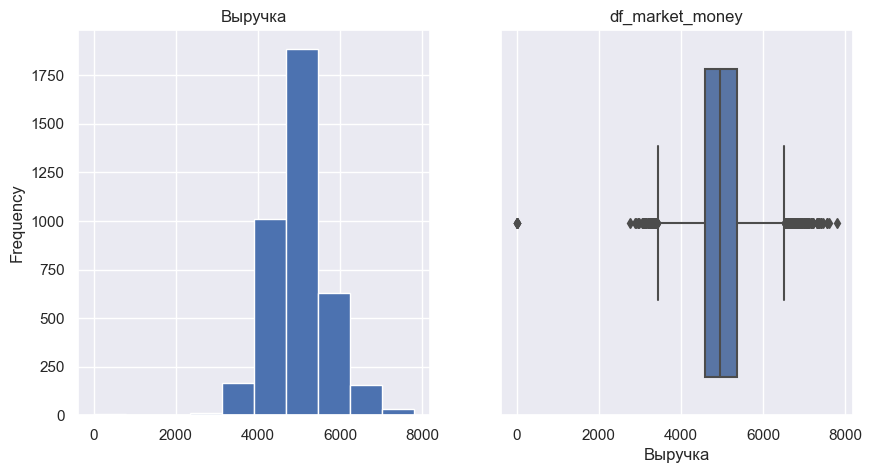

In [6]:
df_market.info()
print(df_market[df_market['Акционные_покупки'] >= 0.6]['Ошибка_сервиса'].count())

display(df_market_money[df_market_money['Выручка'] > 20000])
df_market_money.loc[df_market_money['Выручка'] > 20000, 'Выручка'] = df_market_money['Выручка'].median()
plot_sub_plot_hist_boxplot(df_market_money.select_dtypes(include=np.number), 'df_market_money')

Распределения количественных признаков показали распределения, близкие к нормальному за исключением:
- df_market - Акционные покупки
- df_market_money - Выручка

Для этих двух признаков имеют место выбросы, которые искажают форму гистограммы.
Проанализируем эти выбросы:

#### df_market - Акционные покупки
Таких выбросов (со значением параметра 'Акционные покупки' >= 0.6) 168 и это более 10 % от общего количества. Отбрасывать их неправильно и надо их оставить и учитывать это при построении моделей.

#### df_market_money - Выручка
Такой выброс только один со значением 106862.2 что сильно превышает медиану и среднее для этой выборки - я предлагаю его не отбросить и заменить медианой для данной выборки

Pie диаграммы для категориальных признаков представлены выше. 
В качестве особых признаков можно указать, что данные между периодами распределены равными частями.
Отбор клиентов с покупательской активностью не менее трёх месяцев я произведу после объединения таблиц в следующей секции.

## 5. Объединение таблиц

In [7]:
df_market_money_piv = df_market_money.pivot(index='id', columns='Период', values='Выручка')
df_market_money_piv.columns = ['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
df_market_money_piv.reset_index(inplace=True)
df_market_all  = df_market.merge(df_market_money_piv, left_on='id', right_on='id', how='left')


df_market_time_piv = df_market_time.pivot(index='id', columns='Период', values='минут')
df_market_time_piv.columns = ['Минут_предыдущий_месяц', 'Минут_текущий_месяц']
df_market_time_piv.reset_index(inplace=True)
df_market_all  = df_market_all.merge(df_market_time_piv, left_on='id', right_on='id', how='left')
display(df_market_all.head())
display(df_market_all.isna().mean())

#df_market_all[df_market_all['id'] == 215348]

df_market_all_active = df_market_all[(df_market_all['Выручка_препредыдущий_месяц'] > 0) & (df_market_all['Выручка_предыдущий_месяц'] > 0) & (df_market_all['Выручка_текущий_месяц'] > 0)]
display(df_market_all.describe())
display(df_market_all_active.describe())
df_market_all_not_active = df_market_all[(df_market_all['Выручка_препредыдущий_месяц'] == 0) | (df_market_all['Выручка_предыдущий_месяц'] == 0) | (df_market_all['Выручка_текущий_месяц'] == 0)]
display(df_market_all_not_active)


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


id                                     0.0
Покупательская активность              0.0
Тип сервиса                            0.0
Разрешить сообщать                     0.0
Маркет_актив_6_мес                     0.0
Маркет_актив_тек_мес                   0.0
Длительность                           0.0
Акционные_покупки                      0.0
Популярная_категория                   0.0
Средний_просмотр_категорий_за_визит    0.0
Неоплаченные_продукты_штук_квартал     0.0
Ошибка_сервиса                         0.0
Страниц_за_визит                       0.0
Выручка_предыдущий_месяц               0.0
Выручка_препредыдущий_месяц            0.0
Выручка_текущий_месяц                  0.0
Минут_предыдущий_месяц                 0.0
Минут_текущий_месяц                    0.0
dtype: float64

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923,4936.920385,4825.206923,5236.572615,13.467692,13.204615
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126,739.597997,405.979663,835.188961,3.932029,4.220589
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,2758.700000,5.000000,4.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000,4496.750000,4583.000000,4706.050000,11.000000,10.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000,5005.000000,4809.000000,5179.550000,13.000000,13.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000,5405.625000,5053.500000,5759.275000,17.000000,16.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,4948.339630,4836.367772,5237.879722,13.469545,13.211257
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,701.228571,333.438742,834.033166,3.936323,4.220222
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4498.500000,4585.000000,4706.600000,11.000000,10.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,5005.500000,4812.000000,5179.600000,13.000000,13.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,5409.000000,5055.000000,5758.600000,17.000000,16.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2,0.0,0.0,4735.0,13,11


Таблицы df_market, df_market_money, df_market_time объединены в таблицу df_market_all по общей колонке **id**, при этом значения из колонки **Период** из двух последних датафреймов развернуты в отдельные колонки, в которых помещено значение из колонки Выручка или минуты.

- Выручка_предыдущий_месяц
- Выручка_препредыдущий_месяц
- Выручка_текущий_месяц
- Минут_предыдущий_месяц
- Минут_текущий_месяц

После операции merge была проведена проверка на пропуски и они не обнаружены.

Кроме того, проведена оценка выборки тех клиентов, которые не совершали покупок три последних месяца подряд - это df_market_all_not_active - и он имеет три строки. В связи с этим так как общее число клиентов 1300 то принято решение отбросить этих трех клиентов и далее работать с датафреймом df_market_all_active, который содержит только тех клиентов, которые делали покупки в последних трех месяцах.

## 6. Корреляционный анализ

In [8]:
interval_cols = list(df_market_all_active.select_dtypes(include=np.number).columns.difference(['id']))
print(interval_cols)
display(df_market_all_active[interval_cols].nunique())
display(df_market_all_active['Маркет_актив_тек_мес'].value_counts())
display(df_market_all_active['Средний_просмотр_категорий_за_визит'].value_counts())

['Акционные_покупки', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Длительность', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Средний_просмотр_категорий_за_визит', 'Страниц_за_визит']


Акционные_покупки                      41  
Выручка_предыдущий_месяц               1121
Выручка_препредыдущий_месяц            789 
Выручка_текущий_месяц                  1239
Длительность                           657 
Маркет_актив_6_мес                     41  
Маркет_актив_тек_мес                   3   
Минут_предыдущий_месяц                 19  
Минут_текущий_месяц                    20  
Неоплаченные_продукты_штук_квартал     11  
Ошибка_сервиса                         10  
Средний_просмотр_категорий_за_визит    6   
Страниц_за_визит                       20  
dtype: int64

4    669
5    320
3    308
Name: Маркет_актив_тек_мес, dtype: int64

3    355
2    312
4    262
5    177
1    106
6    85 
Name: Средний_просмотр_категорий_за_визит, dtype: int64

,Акционные_покупки,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Длительность,Маркет_актив_6_мес,Маркет_актив_тек_мес,Минут_предыдущий_месяц,Минут_текущий_месяц,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Покупательская активность,Популярная_категория,Разрешить сообщать,Средний_просмотр_категорий_за_визит,Страниц_за_визит,Тип сервиса
Акционные_покупки,1.000000,0.069144,0.224668,0.063544,0.000000,0.278729,0.000000,0.262189,0.250014,0.240499,0.000000,0.506991,0.122840,0.017252,0.199417,0.310741,0.033339
Выручка_предыдущий_месяц,0.069144,1.000000,0.351374,0.832783,0.130041,0.153128,0.061530,0.124840,0.195297,0.192665,0.000000,0.223652,0.249578,0.069182,0.098538,0.145953,0.000000
Выручка_препредыдущий_месяц,0.224668,0.351374,1.000000,0.410449,0.099332,0.313338,0.000000,0.420746,0.341973,0.258201,0.141271,0.493370,0.047188,0.000000,0.176040,0.334298,0.064912
Выручка_текущий_месяц,0.063544,0.832783,0.410449,1.000000,0.143251,0.000000,0.000000,0.233941,0.258630,0.174656,0.000000,0.193296,0.239610,0.079581,0.087571,0.132807,0.123721
Длительность,0.000000,0.130041,0.099332,0.143251,1.000000,0.000000,0.177132,0.044660,0.107206,0.145909,0.188244,0.099820,0.000000,0.253618,0.190417,0.120363,0.404746
Маркет_актив_6_мес,0.278729,0.153128,0.313338,0.000000,0.000000,1.000000,0.080454,0.363780,0.328385,0.274197,0.147270,0.546370,0.149812,0.000000,0.205783,0.394108,0.094182
Маркет_актив_тек_мес,0.000000,0.061530,0.000000,0.000000,0.177132,0.080454,1.000000,0.106879,0.062485,0.140581,0.116310,0.000000,0.136175,0.051971,0.246726,0.000000,0.044796
Минут_предыдущий_месяц,0.262189,0.124840,0.420746,0.233941,0.044660,0.363780,0.106879,1.000000,0.410490,0.256541,0.244071,0.685078,0.195219,0.042350,0.159393,0.478787,0.131084
Минут_текущий_месяц,0.250014,0.195297,0.341973,0.258630,0.107206,0.328385,0.062485,0.410490,1.000000,0.231617,0.178471,0.575662,0.089923,0.000000,0.182708,0.382533,0.000000
Неоплаченные_продукты_штук_квартал,0.240499,0.192665,0.258201,0.174656,0.145909,0.274197,0.140581,0.256541,0.231617,1.000000,0.043027,0.504870,0.251523,0.204526,0.322170,0.358553,0.140387


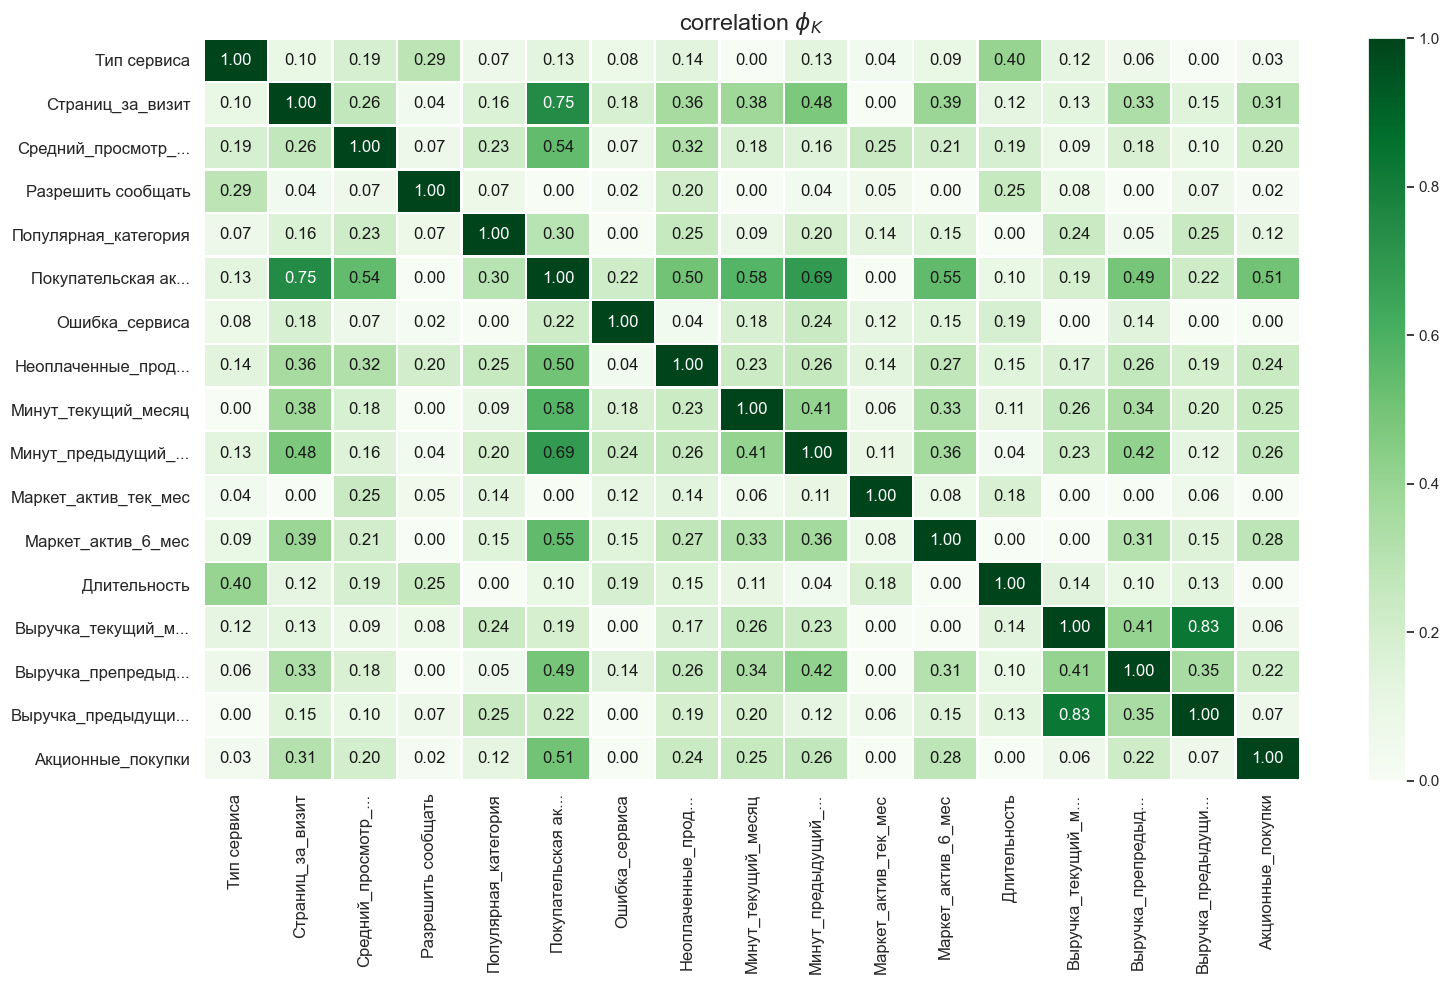

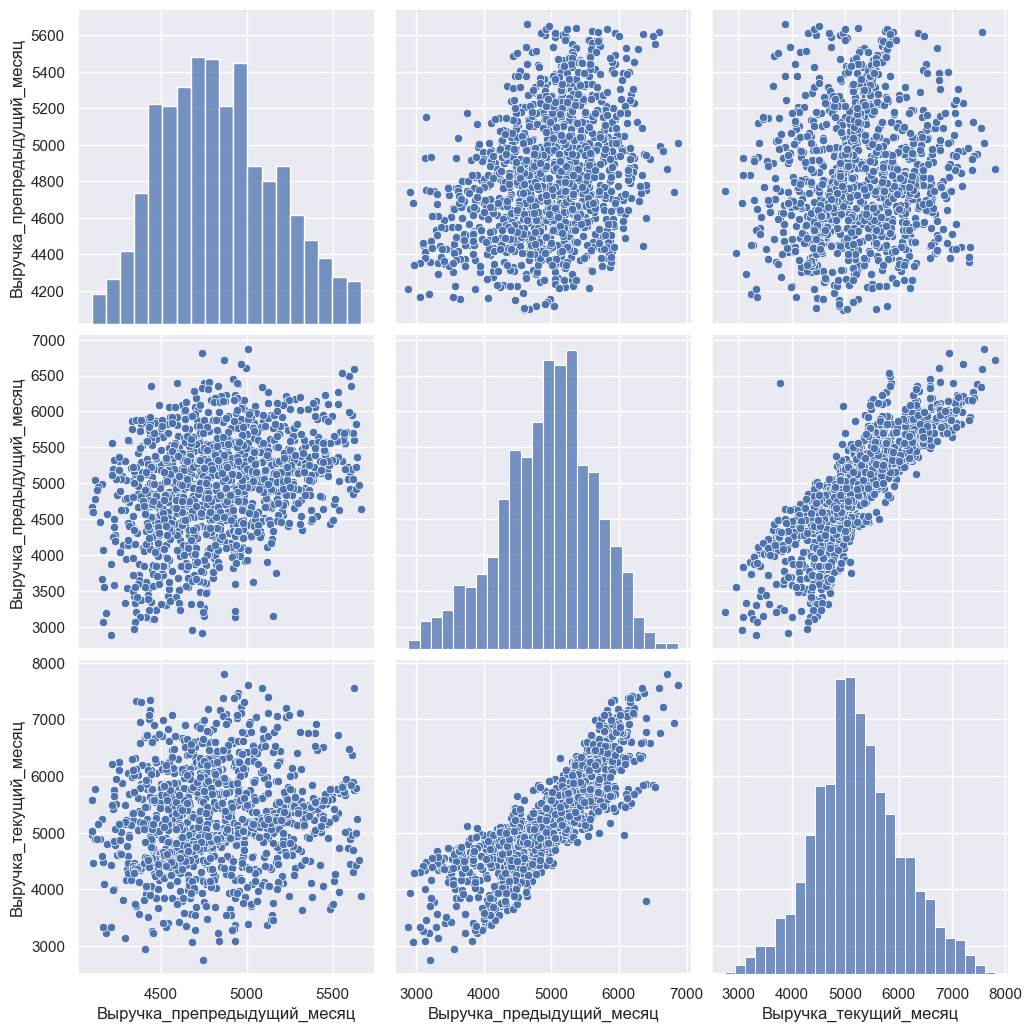

In [9]:
interval_cols = df_market_all_active.select_dtypes(include=np.number).columns.difference(['id'])

#phik_overview = phik_matrix(df_market_all_active[df_market_all_active.columns.difference(['id']).difference(['Покупательская активность'])], interval_cols=list(interval_cols))
phik_overview = phik_matrix(df_market_all_active[df_market_all_active.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(16, 10)
)

sns.pairplot(df_market_all_active[['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']], height=3.5)
plt.show()


Корреляционый анализ с помощью фик матрицы показал, что:
- нет сильных корреляций ~ 1 между целевым признаком (Покупательская активность) и остальными признаками
- есть достаточно сильная кореляция - 0.83 - между признаками Выручка_текущий_месяц и Выручка_предыдущий_месяц

Я не вижу необходимости убирать какие либо признаки на основании этого анализа.

## 7. Использование пайплайнов

### 7.1 Использование ColumnTransformer для подготовки данных 

In [10]:
df_market_all_active['Покупательская активность'].value_counts()

Прежний уровень    802
Снизилась          495
Name: Покупательская активность, dtype: Int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_market_all_active.drop(['Покупательская активность','id'], axis=1),
    df_market_all_active['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_market_all_active['Покупательская активность'])

ohe_columns = list(X_train.select_dtypes(exclude=np.number))
num_columns = list(X_train.select_dtypes(include=np.number))

print(ohe_columns)
print(num_columns)

ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)



['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц']


Создан объект типа ColumnTransformer для подготовки данных. Использовались пайплайны  ohe_pipe для категориальных признаков и 'num'для непрерывных. SimpleImputer не использовался так как до этого уже проводилась проверка на наличие пропусков.

### 7.2 Обучение четырех моделей: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC()

In [12]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели SVC() 
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear')],
        'models__degree': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]
custom_scorer = make_scorer(precision_score, greater_is_better=True,  pos_label="Снизилась")

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

result = pd.DataFrame(grid_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 


,rank_test_score,param_models,mean_test_score,params
61,1,"SVC(degree=2, kernel='linear', random_state=42)",0.902353,"{'models': SVC(degree=2, kernel='linear', random_state=42), 'models__degree': 5, 'preprocessor__num': MinMaxScaler()}"
64,1,"SVC(degree=2, kernel='linear', random_state=42)",0.902353,"{'models': SVC(degree=2, kernel='linear', random_state=42), 'models__degree': 6, 'preprocessor__num': MinMaxScaler()}"
55,1,"SVC(degree=2, kernel='linear', random_state=42)",0.902353,"{'models': SVC(degree=2, kernel='linear', random_state=42), 'models__degree': 3, 'preprocessor__num': MinMaxScaler()}"
52,1,"SVC(degree=2, kernel='linear', random_state=42)",0.902353,"{'models': SVC(degree=2, kernel='linear', random_state=42), 'models__degree': 2, 'preprocessor__num': MinMaxScaler()}"
58,1,"SVC(degree=2, kernel='linear', random_state=42)",0.902353,"{'models': SVC(degree=2, kernel='linear', random_state=42), 'models__degree': 4, 'preprocessor__num': MinMaxScaler()}"
...,...,...,...,...
13,76,DecisionTreeClassifier(random_state=42),0.615643,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 3, 'models__max_features': 2, 'preprocessor__num': MinMaxScaler()}"
14,76,DecisionTreeClassifier(random_state=42),0.615643,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 3, 'models__max_features': 2, 'preprocessor__num': 'passthrough'}"
11,79,DecisionTreeClassifier(random_state=42),0.606655,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 5, 'preprocessor__num': 'passthrough'}"
10,79,DecisionTreeClassifier(random_state=42),0.606655,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 2, 'models__max_features': 5, 'preprocessor__num': MinMaxScaler()}"


### 7.3 Выбор лучшей модели, используя заданную метрику.

In [13]:
print('Лучшая модель:\n\n', grid_search.best_estimator_)
print('Параметры:\n\n', grid_search.best_params_)
print ('Метрика  make_scorer(precision_score, greater_is_better=True,  pos_label="Снизилась") лучшей модели на тренировочной выборке:', grid_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = grid_search.predict(X_test)
display(pd.DataFrame(y_test_pred).head())
# print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные

,0
0,Прежний уровень
1,Снизилась
2,Прежний уровень
3,Снизилась
4,Снизилась


- Выбрана лучшая модель SVC(degree=2, kernel='linear', random_state=42) c скейлером MinMaxScaler
- Метрика  make_scorer(precision_score, greater_is_better=True,  pos_label="Снизилась") лучшей модели на тренировочной выборке: 0.9023529263179165

## 8. Анализ важности признаков

### 8.1 Оценка важности признаков для лучшей модели и построение графика важности с помощью метода SHAP

['Тип сервиса_стандарт', 'Разрешить сообщать_нет', 'Популярная_категория_Косметика и аксесуары', 'Популярная_категория_Кухонная посуда', 'Популярная_категория_Мелкая бытовая техника и электроника', 'Популярная_категория_Техника для красоты и здоровья', 'Популярная_категория_Товары для детей', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц']


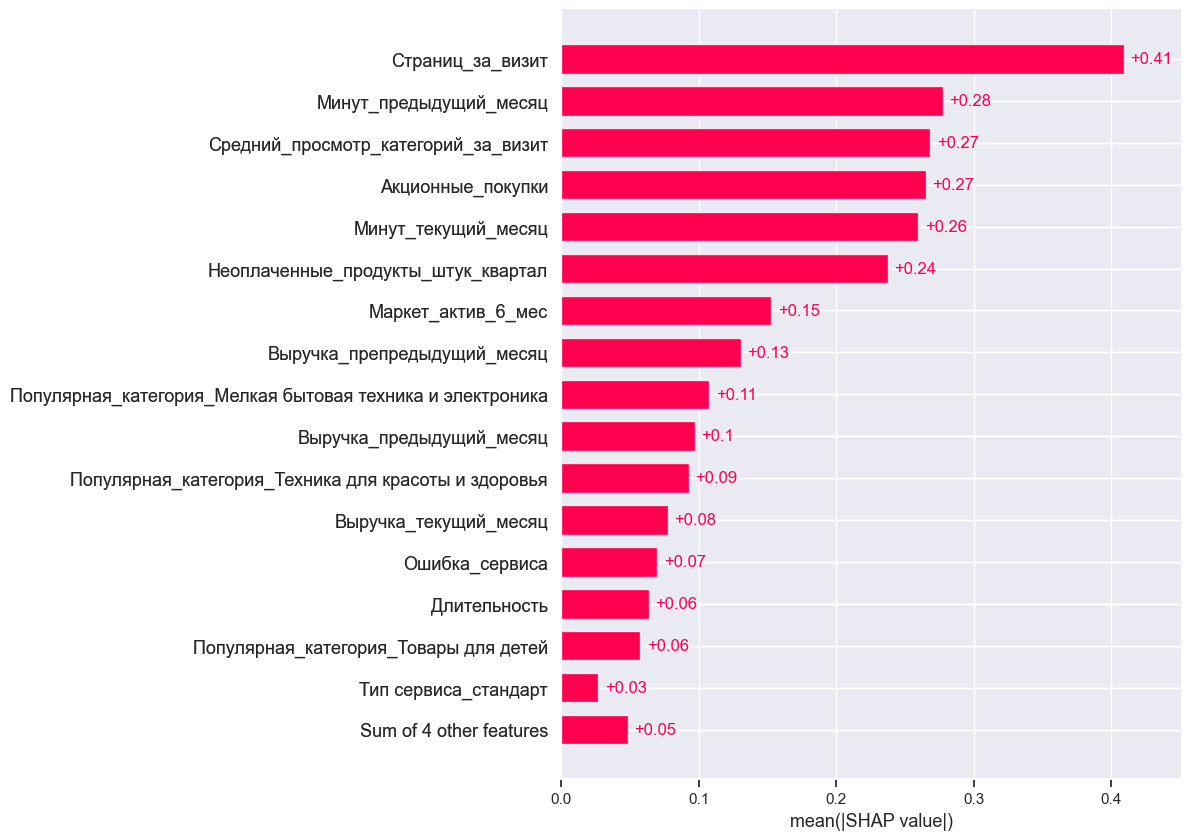

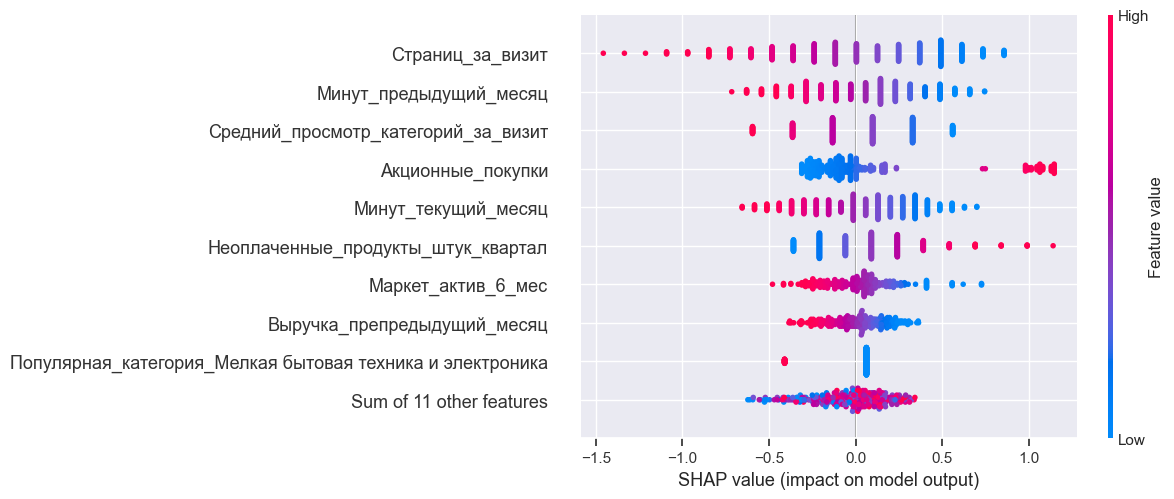

In [21]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test)

nums = pipe_final.named_steps['preprocessor'].transformers_[1][2]
cats = list(pipe_final.named_steps['preprocessor'].named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns))
feature_names = cats + nums
print(feature_names)

explainer = shap.LinearExplainer(grid_search.best_estimator_.named_steps['models'], X_train_transformed)
explainer.feature_names = feature_names
shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values, max_display=17) 
shap.plots.beeswarm(shap_values)

### 8.2 Выводы о значимости признаков

По результатам постороения SHAP графиков сделаны следующие выводы:
#### График Mean(SHAP values)
Признаки наиболее влияюшие на целевой - в порядке убывания:
   - Страниц_за_визит
   - Минут_предыдущий_месяц
   - Средний_просмотр_категорий_за_визит
   - Акционные_покупки
   - Минут_текущий_месяц
   - Неоплаченные_продукты_штук_квартал
#### График SHAP value Impact on model output
Дает более подбробную расшифровку влияния на целевой признак по сравнению с предыдущим графиком
- Уберем из рассмотрения признаки: Минут_предыдущий_месяц, Средний_просмотр_категорий_за_визит и Минут_текущий_месяц так как их распределение симметрично относительно вертикальной линии 0 и они одинаково влияют на целевой признак в ту и в другую сторону
- По оставшимся признакам можно сделать следующие выводы:
   - Страниц_за_визит: Красные значения расположены слева от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 0 то есть к категории "Прежний уровень"
   - Акционные_покупки: Красные значения расположены справа от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 1 то есть к категории "Снизилась"
   - Неоплаченные_продукты_штук_квартал: : Красные значения расположены справа от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 1 то есть к категории "Снизилась"
- Это можно трактовать как:
   - При большом количестве просмотренных страниц сайта за визит увеличивается заинтересованность клиента в покупках что приводит к увеличению или по крайней мере не снижению его покупательской активности
   - При большом количестве доли акционных покупок снижется интерес клиента к обычным покупкам так как он постоянно ждет появления акций  что приводит к снижению его покупательской активности
   - При большом количестве неоплаченных товаров в корзине за последние 3 месяца снижается его покупательская активность так как он не делает покупки при этом
 
#### Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?
Если бизнес-целью считать увеличение покупательной способности клиентов, то можно сформулировать следущие выводы:
- уменьшать количество акционных покупок
- вкладывать средства в развитие сайта интернет-магазина

## 9. Выполнить сегментацию покупателей и предложить, как увеличить покупательскую активность выбранного сегмента

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95


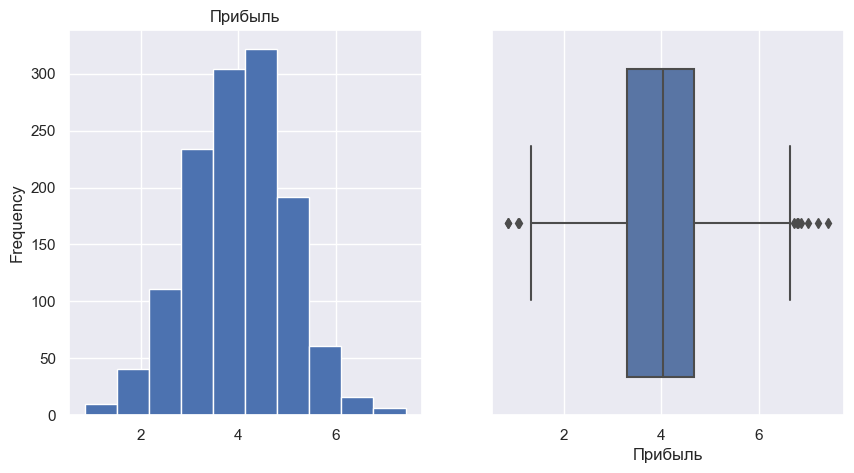

Прежний уровень    884
Снизилась          413
Name: Покупательская активность_предсказ, dtype: int64

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Покупательская активность_предсказ
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16,Снизилась
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87,Снизилась
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21,Снизилась
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,4.93,Снизилась
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6,4.55,Снизилась


<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 1285
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   211 non-null    int64  
 1   Покупательская активность            211 non-null    string 
 2   Тип сервиса                          211 non-null    string 
 3   Разрешить сообщать                   211 non-null    string 
 4   Маркет_актив_6_мес                   211 non-null    float64
 5   Маркет_актив_тек_мес                 211 non-null    int64  
 6   Длительность                         211 non-null    int64  
 7   Акционные_покупки                    211 non-null    float64
 8   Популярная_категория                 211 non-null    string 
 9   Средний_просмотр_категорий_за_визит  211 non-null    int64  
 10  Неоплаченные_продукты_штук_квартал   211 non-null    int64  
 11  Ошибка_сервиса                 

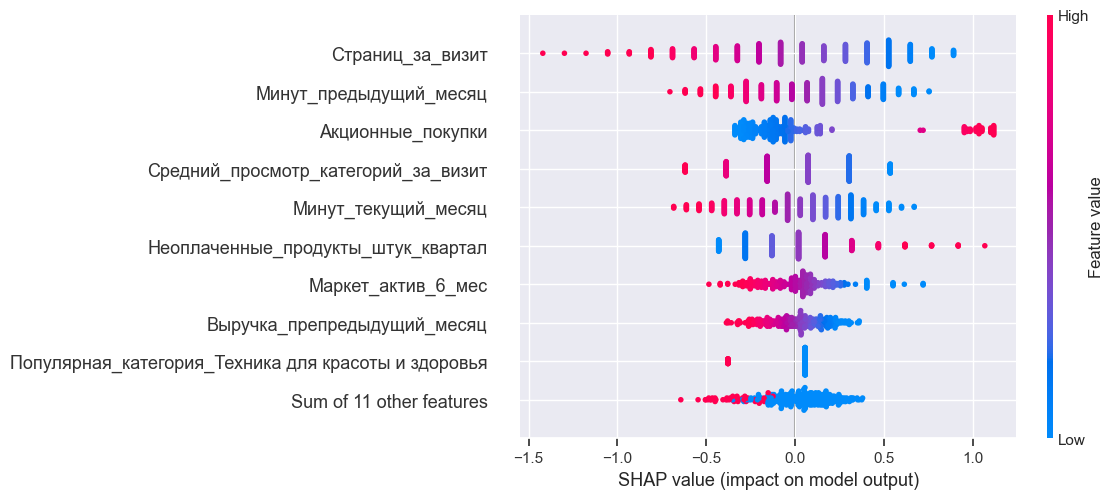

In [156]:
df_market_segmented  = df_market_all_active.merge(df_money, left_on='id', right_on='id', how='left')
display(df_market_segmented.head())
df_market_segmented['Прибыль'].value_counts()
plot_sub_plot_hist_boxplot(df_market_segmented[['Прибыль']], '')
X_test_segmented = df_market_segmented.drop(['Покупательская активность','id', 'Прибыль'], axis=1)
X_test_segmented_transformed = pipe_final.named_steps['preprocessor'].transform(X_test_segmented)
y_segmented_pred = grid_search.predict(X_test_segmented)
y_segmented_pred_df = pd.DataFrame(y_segmented_pred)
y_segmented_pred_df.columns = ['Покупательская активность_предсказ']
y_segmented_pred_df.head()
df_market_segmented_with_prib = pd.concat([df_market_segmented, y_segmented_pred_df], axis=1)
display(df_market_segmented_with_prib['Покупательская активность_предсказ'].value_counts())
df_market_segmented_with_prib.head()
df_market_segmented_with_prib_selected = df_market_segmented_with_prib[(df_market_segmented_with_prib['Покупательская активность_предсказ'] == 'Снизилась') & (df_market_segmented_with_prib['Прибыль'] > df_market_segmented_with_prib['Прибыль'].median())]
display(df_market_segmented_with_prib_selected.head())
df_market_segmented_with_prib_selected.info()
df_market_segmented_with_prib_selected.describe()

explainer = shap.LinearExplainer(grid_search.best_estimator_.named_steps['models'], X_test_segmented_transformed)
explainer.feature_names = feature_names
shap_values = explainer(X_test_transformed)
shap.plots.beeswarm(shap_values)


Для сегментации выбран сегмент - Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.
В качестве критерия высоко прибыльности были выбраны клиенты, прибыль которых выше медианы распределения в колонке Прибыль и у которых предсказанная по выбранной модели Покупательская активность = Снизилась

Для полученного датафрейма я еще раз построил график SHAP value Impact on model output и полученные результаты и выводы совпадают с теми, которые были сделаны для всего датафрейма - единственное отличие для данного датафрейма что у него немного другой порядок high rank items. Повторю ранее сделанные выводы здесь для выбранного сегмента:
#### Признаки наиболее влияющие на целевой признак:
   - Страниц_за_визит: Красные значения расположены слева от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 0 то есть к категории "Прежний уровень"
   - Акционные_покупки: Красные значения расположены справа от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 1 то есть к категории "Снизилась"
   - Неоплаченные_продукты_штук_квартал: : Красные значения расположены справа от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 1 то есть к категории "Снизилась"
- Это можно трактовать как:
   - При большом количестве просмотренных страниц сайта за визит увеличивается заинтересованность клиента в покупках что приводит к увеличению или по крайней мере не снижению его покупательской активности
   - При большом количестве доли акционных покупок снижется интерес клиента к обычным покупкам так как он постоянно ждет появления акций  что приводит к снижению его покупательской активности
   - При большом количестве неоплаченных товаров в корзине за последние 3 месяца снижается его покупательская активность так как он не делает покупки при этом
 
#### Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?
Если бизнес-целью считать увеличение покупательной способности клиентов, то можно сформулировать следущие выводы:
- уменьшать количество акционных покупок
- вкладывать средства в развитие сайта интернет-магазина

## 10. Общий вывод

### 10.1 Описание задачи

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

#### Шаги по решению задачи:
- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
- Нужно собрать данные по клиентам по следующим группам:
  * Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
  * Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто
  * Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магази
  * Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте
 
#### Требования
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения. едложения.е.

### 10.2 Описание исходных данных и проведённой предобработки

Входные данные представлены в виде четырех CSV файлов:

- market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Она содержит столбцы:
  - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
  - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
  - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
  - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
  - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
  - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
  - Акционные_покупкСредний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
  - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
  - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
  - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.и — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
  - Популярная_категория — самая популярная категория товаров у покупателя за посл
- market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом
  - id - номер покупателя в корпоративной базе данных.
  - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
  - Выручка — сумма выручки за пери
- market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
  - id — номер покупателя в корпоративной базе данных.
  - Период — название периода, во время которого зафиксировано общее время.
  - минут — значение времени, проведённого на сайте, в минут
- money.csv - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
  - id — номер покупателя в корпоративной базе данных.
  - Прибыль — значение прибы
 
Для построения модели используются таблицы market_file.csv, market_money.csv, market_time.csv

В качестве обработки данных использовались:
- проверка на дубликаты по id
- проверка на пропуски
- проверка на выбросы
- исправление грамматических ошибок в кат признаках с целью приведения их к общему виду       лии.ах.ах.од.д.едние 6 месяцев

### 10.3 Что было сделано для поиска лучшей модели?

Для поиска лучше модели использовался пайплайн c вариацией по четырем моделям:
- KNeighborsClassifier()
- DecisionTreeClassifier()
- LogisticRegression()
- SVC()

и вариацией определенных гиперпараметров для каждой из моделей а также вариацией по двум типам скейлеров:
- StandardScaler()
- MinMaxScaler()


### 10.4 Указать лучшую модель
В результате поиска по метрике  make_scorer(precision_score, greater_is_better=True,  pos_label="Снизилась") была найдена модель  SVC(degree=2, kernel='linear', random_state=42) c скейлером MinMaxScaler. Значение метрики =  0.9023529263179165


### 10.5 Добавить выводы и дополнительные предложения для выбранного сегмента покупателей

Для сегментации выбран сегмент - Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. В качестве критерия высоко прибыльности были выбраны клиенты, прибыль которых выше медианы распределения в колонке Прибыль и у которых предсказанная по выбранной модели Покупательская активность = Снизилась

По результатам исследования для данного сегмента были сделданы выводы и предложения:

#### Признаки наиболее влияющие на целевой признак:
   - Страниц_за_визит: Красные значения расположены слева от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 0 то есть к категории "Прежний уровень"
   - Акционные_покупки: Красные значения расположены справа от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 1 то есть к категории "Снизилась"
   - Неоплаченные_продукты_штук_квартал: : Красные значения расположены справа от линии 0 - это означает что этот признак уведичивает вероятность принадлежности к классу 1 то есть к категории "Снизилась"
- Это можно трактовать как:
   - При большом количестве просмотренных страниц сайта за визит увеличивается заинтересованность клиента в покупках что приводит к увеличению или по крайней мере не снижению его покупательской активности
   - При большом количестве доли акционных покупок снижется интерес клиента к обычным покупкам так как он постоянно ждет появления акций  что приводит к снижению его покупательской активности
   - При большом количестве неоплаченных товаров в корзине за последние 3 месяца снижается его покупательская активность так как он не делает покупки при этом
 
#### Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?
Если бизнес-целью считать увеличение покупательной способности клиентов, то можно сформулировать следущие выводы:
- уменьшать количество акционных покупок
- вкладывать средства в развитие сайта интернет-магазина